# Social Network Analysis

The Spotify Million Playlist Dataset contains 1,000,000 user-generated playlists from the Spotify platform, created between January 2010 and October 2017. Each playlist includes metadata such as playlist titles and track titles. This large-scale dataset supports research in music recommendation systems, particularly in tasks like automatic playlist continuation.

In order to run the following notebook it's required to download the full dataset (which is available [here](https://www.aicrowd.com/challenges/spotify-million-playlist-dataset-challenge/)) and place the `/spotify_million_playlist_dataset` directory under `/data`.

A pre-built network is available under `data/graph.pkl`

In [95]:
import os
import json
import pandas as pd
import numpy as np
from collections import Counter
from collections import deque
import networkx as nx
import matplotlib.pyplot as plt
import pickle

plt.style.use('./style.mpl')

In order to build the network we select a random set of slices and we build a dataframe in the form

| pid       | artist_count |
| --------- | ------------ |
| 596487    | {'Justin Timberlake': 3, 'Pharrell Williams': ... }    |
| 596487    | {'Calvin Harris': 5, '50 Cent': 1, 'Kanye West': ... } |
| ...       | ...                                                    |

This way we know how many times a given artist appear in a user's playlist and we can build a co-occurrence network where frequent pairings in playlists get heavier edges.

In [96]:
data_path = os.path.join("data/spotify_million_playlist_dataset/data")

slices = [f for f in os.listdir(data_path)]

np.random.seed(42)
np.random.shuffle(slices)

df = pd.DataFrame()
for s in slices[:10]:
    with open(os.path.join(data_path, s)) as f:
        data = json.load(f)

    playlists = data['playlists']

    rows = []
    for playlist in playlists:
        pid = playlist['pid']
        artist_names = [track['artist_name'] for track in playlist['tracks']]
        artist_count = dict(Counter(artist_names))
        rows.append({'pid': pid, 'artist_count': artist_count})

    dd = pd.DataFrame(rows)
    dd.set_index('pid', inplace=True)

    df = pd.concat([df, dd], axis=0)

In [97]:
df.head()

,artist_count
pid,
249000,"{'José Feliciano': 1, 'Gene Autry': 2, 'Brenda..."
249001,"{'Vampire Weekend': 5, 'Hozier': 4, 'The 1975'..."
249002,"{'Moon Taxi': 1, 'JAHKOY': 1, 'MKTO': 1, 'The ..."
249003,"{'X Ambassadors': 6, 'AWOLNATION': 1, 'Imagine..."
249004,"{'Tedashii': 10, 'Lecrae': 30, 'KJ-52': 2, 'to..."


In [98]:
print(f"Data shape: {df.shape}")
print(f"Number of playlists: {len(df)}")

Data shape: (10000, 1)
Number of playlists: 10000


Now let's build a dataframe that stores playlist-artist relation such that the resulting structure will resemble the following

| pid       | artist        |
| --------- | ------------- |
| 596487    | Calvin Harris |
| 596487    | 50 Cent       |
| ...       | ...           |

In [99]:
playlist_artist_rows = []

for pid, row in df.iterrows():
    artist_count = row['artist_count']
    for artist in artist_count.keys():
        playlist_artist_rows.append({'pid': pid, 'artist': artist})

playlist_artist_df = pd.DataFrame(playlist_artist_rows)
playlist_artist_df['artist'] = playlist_artist_df['artist'].apply(lambda x: x.replace('$', 'S'))

In [100]:
playlist_artist_df.head()

print(f"Data shape: {playlist_artist_df.shape}")
print(f'Number of unique artists: {playlist_artist_df.artist.nunique()}')

Data shape: (385846, 2)
Number of unique artists: 36038


In [101]:
df_reducted = df.sample(100, random_state=42).copy()

In [ ]:
G = nx.Graph()

# Iterate over all playlist rows
for PID, row in df_reducted.iterrows():
    artist_dict = row['artist_count']  # Get the artist dictionary

    # Create nodes for each artist
    artist_array = [(artist, frequency) for artist, frequency in artist_dict.items()]
    for node_name, node_frequency in artist_array:
        if not G.has_node(node_name):
            G.add_node(node_name, frequency=node_frequency)

    # Add weighted edges between artists in the same playlist
    artist_deque = deque(artist_array)
    while artist_deque:
        left_artist = artist_deque.popleft()
        left_name, left_freq = left_artist
        for right_name, right_freq in artist_deque:
            if G.has_edge(left_name, right_name):
                G[left_name][right_name]['weight'] += min(left_freq, right_freq)
            else:
                G.add_edge(left_name, right_name, weight = min(left_freq, right_freq))    

In [103]:
print(G)
print(f"Is the graph connected? {nx.is_connected(G)}")

Graph with 2516 nodes and 129667 edges
Is the graph connected? False


In [104]:
subgraph = nx.Graph(G)
edges_to_remove = [(u, v) for u, v, d in subgraph.edges(data=True) if d['weight'] < 2]
subgraph.remove_edges_from(edges_to_remove)

subgraph = nx.subgraph(subgraph, sorted(nx.connected_components(subgraph), key=len, reverse=True)[0])

print(subgraph)
print(f"Is the graph connected? {nx.is_connected(subgraph)}")

Graph with 1139 nodes and 17908 edges
Is the graph connected? True


Dump the graph and the dataset

In [105]:
pickle.dump(subgraph, open('data/network.pkl', 'wb'))
pd.to_pickle(df, 'data/artist_count.pkl')
pd.to_pickle(playlist_artist_df, 'data/playlist_artist.pkl')

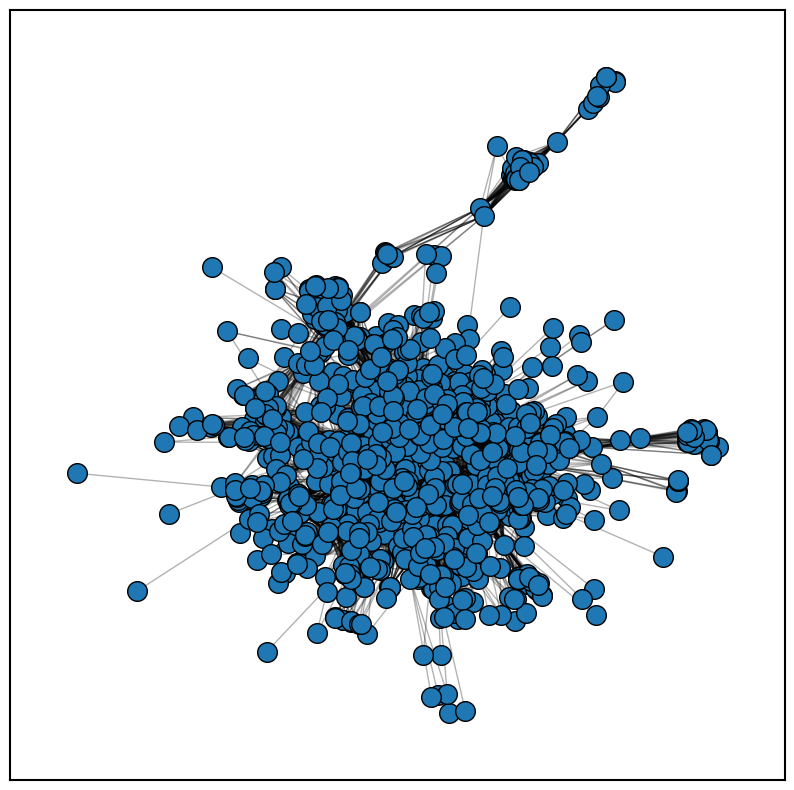

In [110]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

pos = nx.spring_layout(subgraph, seed=42)

nx.draw_networkx_nodes(subgraph, pos, edgecolors='black', node_size=200)
nx.draw_networkx_edges(subgraph, pos, edge_color='black', alpha=0.3)

plt.savefig('plots/full-network.png', transparent=True)
plt.show()

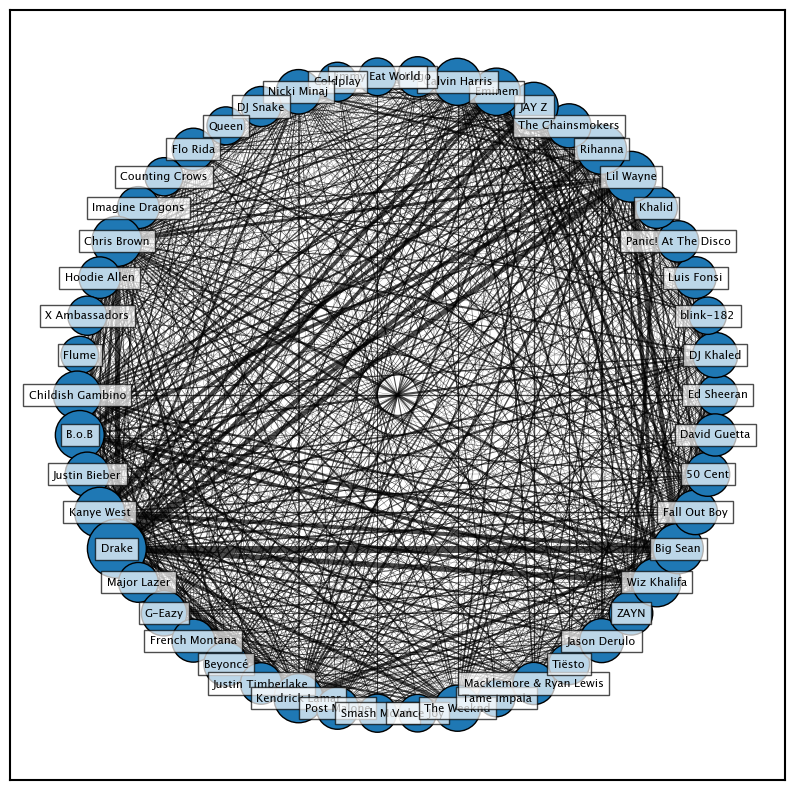

In [107]:
top_nodes = sorted(G.degree, key=lambda x: x[1], reverse=True)[:50]
subgraph_nodes = [node for node, _ in top_nodes]
top_artists_subgraph = G.subgraph(subgraph_nodes)

node_popularity = dict(top_artists_subgraph.degree(weight='weight'))
max_popularity = max(node_popularity.values()) if node_popularity else 1

node_popularity = dict(top_artists_subgraph.degree(weight='weight'))
max_popularity = max(node_popularity.values()) if node_popularity else 1

node_sizes = [600 + (node_popularity[n] / max_popularity) * 1200 for n in top_artists_subgraph.nodes()]

edge_weights = [top_artists_subgraph[u][v]['weight'] for u, v in top_artists_subgraph.edges()]
max_weight = max(edge_weights) if edge_weights else 1
normalized_weights = [w / max_weight * 5 for w in edge_weights]

plt.figure(figsize=(10, 10))
pos = nx.circular_layout(top_artists_subgraph)

nx.draw_networkx_nodes(top_artists_subgraph, pos, node_size=node_sizes, edgecolors='black')
nx.draw_networkx_edges(top_artists_subgraph, pos, width=normalized_weights, edge_color='black', alpha=0.7)
nx.draw_networkx_labels(top_artists_subgraph, pos, font_size=8, verticalalignment='center', bbox=dict(facecolor='white', alpha=0.7, edgecolor='black'))

plt.savefig('plots/top-50-artists.png', transparent=True)
plt.show()